<a href="https://colab.research.google.com/github/enesaktepe78/smoking-detection/blob/master/test_smoking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%ls

datalab/  sample_data/


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
%cd ~
  
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive

!pip install -q pycocotools

!pip install --upgrade tf_slim

%cd ~/models/research
!protoc object_detection/protos/*.proto --python_out=.

/root
fatal: destination path 'models' already exists and is not an empty directory.
     |████████████████████████████████| 358kB 2.8MB/s 
/root/models/research
object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [4]:
%cd ~
!mkdir datalab

/root
mkdir: cannot create directory ‘datalab’: File exists


In [5]:
!mkdir /content/datalab/

mkdir: cannot create directory ‘/content/datalab/’: File exists


In [6]:
#from google.colab import drive

# This will prompt for authorization.
#drive.mount('/content/drive')

In [7]:
"""
zip_id = '1tq8VG8qhZdhzSp1bg3bAGAsQ-q_6FI15'

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists('MODEL'):
    os.makedirs('MODEL')

# DOWNLOAD ZIP
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('cigarette_model.zip')

# UNZIP ZIP
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('cigarette_model.zip', 'r')
zip_ref.extractall('/content/datalab/')
zip_ref.close()
"""

'\nzip_id = \'1tq8VG8qhZdhzSp1bg3bAGAsQ-q_6FI15\'\n\nfrom pydrive.auth import GoogleAuth\nfrom pydrive.drive import GoogleDrive\nfrom google.colab import auth\nfrom oauth2client.client import GoogleCredentials\nimport zipfile, os\n\n# 1. Authenticate and create the PyDrive client.\nauth.authenticate_user()\ngauth = GoogleAuth()\ngauth.credentials = GoogleCredentials.get_application_default()\ndrive = GoogleDrive(gauth)\n\nif not os.path.exists(\'MODEL\'):\n    os.makedirs(\'MODEL\')\n\n# DOWNLOAD ZIP\nprint ("Downloading zip file")\nmyzip = drive.CreateFile({\'id\': zip_id})\nmyzip.GetContentFile(\'cigarette_model.zip\')\n\n# UNZIP ZIP\nprint ("Uncompressing zip file")\nzip_ref = zipfile.ZipFile(\'cigarette_model.zip\', \'r\')\nzip_ref.extractall(\'/content/datalab/\')\nzip_ref.close()\n'

In [8]:
%cd '/content/datalab/'

!gdown --id 1tq8VG8qhZdhzSp1bg3bAGAsQ-q_6FI15

/content/datalab
Downloading...
From: https://drive.google.com/uc?id=1tq8VG8qhZdhzSp1bg3bAGAsQ-q_6FI15
To: /content/datalab/cigarette_model.zip
48.6MB [00:00, 155MB/s] 


In [9]:
%cd '/content/datalab/'
!unzip -q cigarette_model.zip

/content/datalab
replace frozen_inference_graph.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [18]:
%cd ~/datalab
 
from google.colab import files
from os import path
 
uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image1.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

/root/datalab


Saving a (549).jpg to a (549).jpg
saved file a (549).jpg


/root/models/research/object_detection


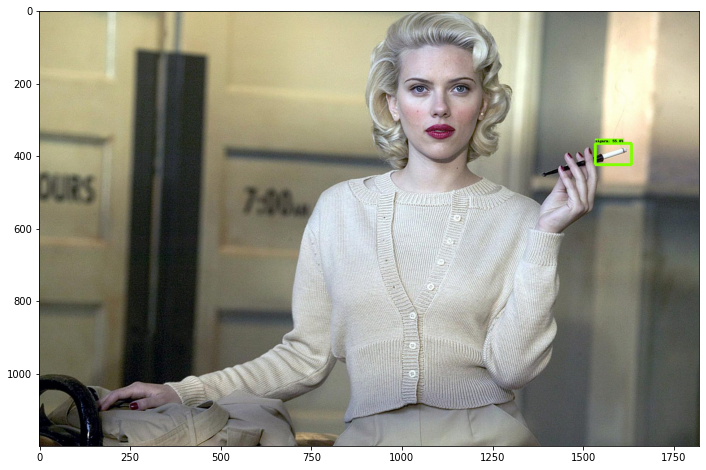

In [19]:
%cd ~/models/research/object_detection
 
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
 
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
 
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
 
# This is needed to display the images.
%matplotlib inline
 
from utils import label_map_util
 
from utils import visualization_utils as vis_util
 

# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/content/datalab' + '/frozen_inference_graph.pb'
 
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/datalab', 'sigara.pbtxt')
 
NUM_CLASSES = 37
 
 
 
 
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
    
    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
 
 
 
 
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)
 
 
 
 
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/root/datalab/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]
 
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
 
 
 
 
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
 
      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})
 
      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict
 
 
 
 
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)